In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

DATA_PATH = "data/UW_VF_Data.csv"
EARLY_CUTOFF = 1.5  #18 months
MIN_FOLLOWUP = 3.0  #3 years minimum
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

In [3]:

df = pd.read_csv(DATA_PATH)

print("Dataset Overview:")
print(f"Total visits: {df.shape[0]:,}")
print(f"Unique patients: {df['PatID'].nunique():,}")
print(f"Unique eyes: {df.groupby(['PatID', 'Eye']).ngroups:,}")
print(f"Follow-up range: {df['Time_from_Baseline'].min():.1f} to {df['Time_from_Baseline'].max():.1f} years")

df.head()

Dataset Overview:
Total visits: 28,943
Unique patients: 3,871
Unique eyes: 7,428
Follow-up range: 0.0 to 20.8 years


,PatID,Gender,Eye,FieldN,Age,Time_from_Baseline,MS,MS_Cluster1,MS_Cluster2,MS_Cluster3,...,PD_45,PD_46,PD_47,PD_48,PD_49,PD_50,PD_51,PD_52,PD_53,PD_54
0,647,F,Right,1,52.7967,0.0000,27.832885,25.57750,26.979231,30.588333,...,-1.92,-0.36,-0.44,-1.52,-0.03,-1.06,0.75,-1.33,-2.02,-0.61
1,647,F,Right,2,53.8234,1.0267,30.131346,27.76000,29.911538,33.263333,...,-0.54,-1.13,-1.81,-1.74,-2.19,-1.23,-4.85,-2.24,0.00,0.28
2,647,F,Right,3,54.8857,2.0890,29.454808,25.47500,29.826154,32.488333,...,-0.07,1.56,-2.09,0.07,-0.84,-2.45,-0.48,-4.10,-1.28,-4.07
3,647,F,Right,4,57.7331,4.9363,27.947885,23.75625,28.658462,31.431667,...,-2.57,-1.74,-0.52,-2.70,-1.48,-3.32,-3.00,-6.49,-2.19,-2.76
4,647,F,Right,5,58.7680,5.9713,27.644038,24.90250,28.104615,30.105000,...,-0.80,-0.93,-3.08,-2.55,-3.26,-3.13,-1.42,-0.18,-1.02,-2.63


In [4]:
def extract_temporal_features_18mo(eye_visits):
    """
    Extract temporal features from visual field visit sequence
    
    Parameters:
    eye_visits : Visits for one eye, sorted by time
    
    Returns:
    dict : Feature dictionary or None if insufficient data
    """

    if len(eye_visits) < 5:
        return None
    
    total_followup = eye_visits['Time_from_Baseline'].max()
    if total_followup < MIN_FOLLOWUP:
        return None
    
    #Split into early (0-18 months) and long-term (>18 months) windows
    early = eye_visits[eye_visits['Time_from_Baseline'] <= EARLY_CUTOFF]
    target = eye_visits[eye_visits['Time_from_Baseline'] > EARLY_CUTOFF]
    
    if len(early) < 2 or len(target) < 2:
        return None
    
    features = {}
    
    #Baseline Features
    baseline = eye_visits.iloc[0]
    features['baseline_MS'] = baseline['MS']
    features['baseline_MTD'] = baseline['MTD']
    features['baseline_PSD'] = baseline['PSD']
    features['baseline_Age'] = baseline['Age']
    
    #Early window features
    times_early = early['Time_from_Baseline'].values.reshape(-1, 1)
    
    #Calculation of slopes using linear regression
    for metric in ['MS', 'MTD', 'PSD']:
        if not early[metric].isna().any():
            lr = LinearRegression()
            lr.fit(times_early, early[metric].values)
            features[f'early_{metric}_slope'] = lr.coef_[0]
        else:
            features[f'early_{metric}_slope'] = np.nan
    
    #Variability measures
    features['early_MS_std'] = early['MS'].std()
    features['early_n_visits'] = len(early)
    
    #Target Window (long-term >18 months)
    times_target = target['Time_from_Baseline'].values.reshape(-1, 1)
    
    if not target['MS'].isna().any():
        lr = LinearRegression()
        lr.fit(times_target, target['MS'].values)
        features['target_longterm_slope'] = lr.coef_[0]
    else:
        features['target_longterm_slope'] = np.nan
    
    #Acceleration
    if not pd.isna(features['early_MS_slope']) and not pd.isna(features['target_longterm_slope']):
        features['MS_acceleration'] = features['target_longterm_slope'] - features['early_MS_slope']
    else:
        features['MS_acceleration'] = np.nan
    
    features['total_followup_years'] = total_followup
    features['PatID'] = baseline['PatID']
    features['Eye'] = baseline['Eye']
    
    return features

In [5]:
#Extract features for each eye
rows = []
skipped = 0

for (pat_id, eye), eye_visits in df.groupby(['PatID', 'Eye']):
    eye_visits_sorted = eye_visits.sort_values('Time_from_Baseline')
    features = extract_temporal_features_18mo(eye_visits_sorted)
    
    if features is not None:
        rows.append(features)
    else:
        skipped += 1

temporal_df = pd.DataFrame(rows)

print(f"Eyes with sufficient data: {len(temporal_df):,}")
print(f"Eyes skipped (insufficient data): {skipped:,}")
print(f"\nDataset shape: {temporal_df.shape}")

temporal_df.head()

Eyes with sufficient data: 1,342
Eyes skipped (insufficient data): 6,086

Dataset shape: (1342, 14)


,baseline_MS,baseline_MTD,baseline_PSD,baseline_Age,early_MS_slope,early_MTD_slope,early_PSD_slope,early_MS_std,early_n_visits,target_longterm_slope,MS_acceleration,total_followup_years,PatID,Eye
0,28.292308,-4.243077,2.007086,51.4360,3.313108,3.370793,-0.760978,1.686994,2,-0.088984,-3.402092,7.2553,15,Left
1,31.859231,-0.676154,1.496418,51.4360,0.681529,0.739214,0.631791,0.347026,2,-0.202847,-0.884376,7.2553,15,Right
2,27.828462,-3.732308,1.409590,68.1396,-0.565251,-0.507940,0.003378,0.439902,2,-0.565627,-0.000375,15.8768,34,Left
3,28.991923,-2.568846,3.586019,68.1396,-0.244951,-0.187233,0.714929,0.797556,3,-0.230078,0.014873,15.8768,34,Right
4,24.826538,-6.557500,3.150458,71.1704,-2.965174,-2.907263,0.623044,1.406463,2,-0.335610,2.629563,10.6749,38,Left


In [6]:
#Define feature sets for model comparison (only using information available at 18 months)
features_full = ['baseline_MS', 'baseline_MTD', 'baseline_PSD', 'baseline_Age', 
                 'early_MS_slope', 'early_MTD_slope', 'early_PSD_slope',
                 'early_MS_std','early_n_visits', 'MS_acceleration']

target = 'target_longterm_slope'

#Remove any rows with missing data
model_data = temporal_df[features_full + [target, 'PatID', 'Eye']].dropna()
print(f"\nFinal dataset size: {len(model_data):,} eyes")
print(f"\nNumber of features: {len(features_full):,}")
print(features_full)


Final dataset size: 1,342 eyes

Number of features: 10
['baseline_MS', 'baseline_MTD', 'baseline_PSD', 'baseline_Age', 'early_MS_slope', 'early_MTD_slope', 'early_PSD_slope', 'early_MS_std', 'early_n_visits', 'MS_acceleration']


In [7]:
#Patient level split to prevent data leakage
unique_patients = model_data['PatID'].unique()
train_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=RANDOM_STATE)

#Create masks for train/test split
train_mask = model_data['PatID'].isin(train_patients)
test_mask = model_data['PatID'].isin(test_patients)

#Verify no overlap
train_pats = model_data[train_mask]['PatID'].nunique()
test_pats = model_data[test_mask]['PatID'].nunique()
overlap = set(model_data[train_mask]['PatID'].unique()) & set(model_data[test_mask]['PatID'].unique())

print("Train/Test Split Results:")
print(f"Training set: {train_mask.sum():,} eyes from {train_pats} patients")
print(f"Testing set:  {test_mask.sum():,} eyes from {test_pats} patients")
print(f"Patient overlap: {len(overlap)}")

Train/Test Split Results:
Training set: 1,073 eyes from 583 patients
Testing set:  269 eyes from 146 patients
Patient overlap: 0


In [8]:
X_train = model_data.loc[train_mask, features_full]
X_test = model_data.loc[test_mask, features_full]
y_train = model_data.loc[train_mask, target]
y_test = model_data.loc[test_mask, target]

print("Training Gradient Boosting Model...")
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")

# Train model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)

gb_model.fit(X_train, y_train)

Training Gradient Boosting Model...
Training samples: 1,073
Testing samples: 269


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [9]:
#Generate predictions
y_pred = gb_model.predict(X_test)

#Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#Display results
print("MODEL PERFORMANCE ON TEST SET")
print(f"\nR² Score: {r2:.3f}")
print(f"\nMAE: {mae:.3f} dB/year")

MODEL PERFORMANCE ON TEST SET

R² Score: 0.713

MAE: 0.234 dB/year


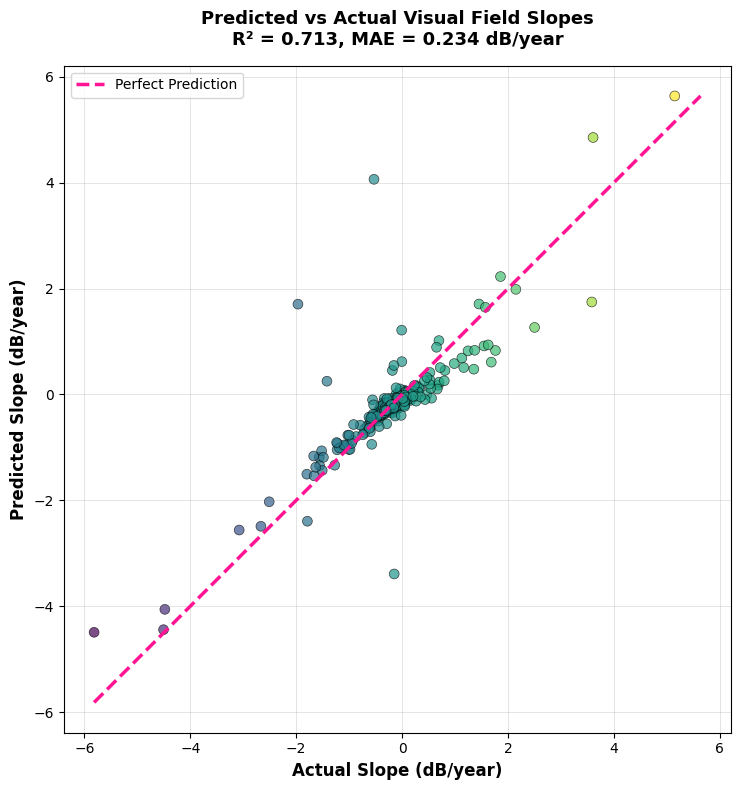

In [10]:
#Predicted vs Actual scatter plot
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
ax.set_facecolor('white')

ax.scatter(y_test, y_pred, alpha=0.7, s=50, c=y_test, cmap='viridis', edgecolors='black', linewidth=0.5)

#Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], color='#FF1493', linestyle='--', lw=2.5, label='Perfect Prediction')

ax.set_xlabel('Actual Slope (dB/year)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Slope (dB/year)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicted vs Actual Visual Field Slopes\nR² = {r2:.3f}, MAE = {mae:.3f} dB/year', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

Feature Importance Ranking:
MS_acceleration           0.7015 ██████████████████████████████████████████████████████████████████████
early_MTD_slope           0.1350 █████████████
early_MS_slope            0.1043 ██████████
early_PSD_slope           0.0241 ██
early_MS_std              0.0200 ██
baseline_MS               0.0084 
baseline_Age              0.0037 
baseline_PSD              0.0017 
early_n_visits            0.0008 
baseline_MTD              0.0004 


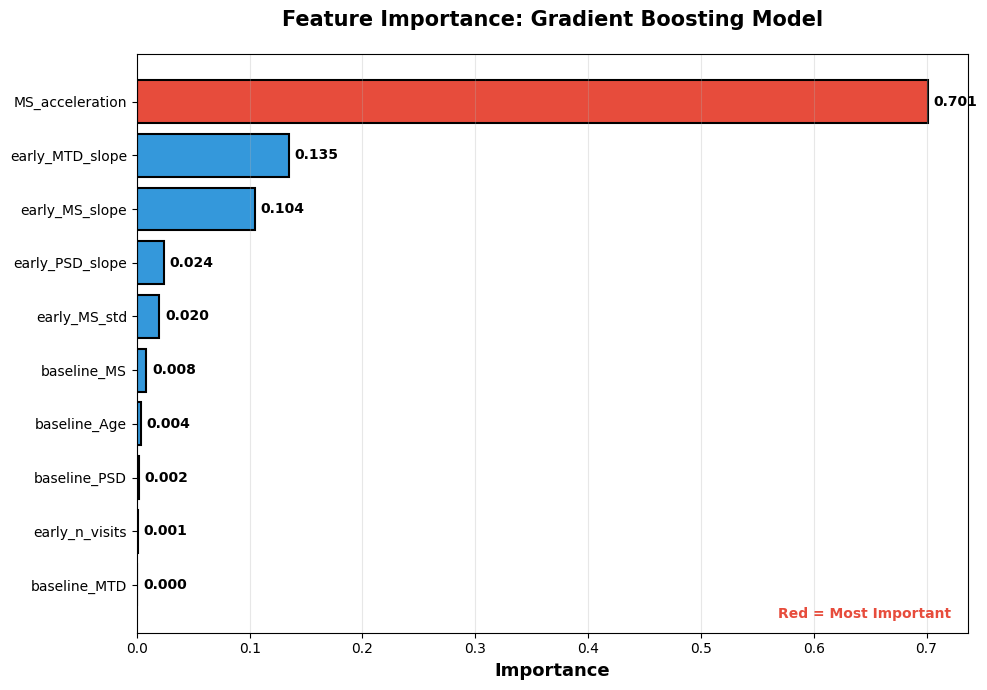

In [11]:
importance_df = pd.DataFrame({
    'Feature': features_full,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']:<25} {row['Importance']:.4f} {'█' * int(row['Importance'] * 100)}")

fig, ax = plt.subplots(figsize=(10, 7))

colors = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(importance_df))]
bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Importance', fontsize=13, fontweight='bold')
ax.set_title('Feature Importance: Gradient Boosting Model', fontsize=15, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, imp) in enumerate(zip(bars, importance_df['Importance'])):
    ax.text(imp + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{imp:.3f}', va='center', fontsize=10, fontweight='bold')

ax.text(0.98, 0.02, 'Red = Most Important', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=10, color='#e74c3c', fontweight='bold')

plt.tight_layout()
plt.show()